# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import csv
import numpy as np

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

sign_names = dict()
with open('signnames.csv') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        sign_names[int(row['ClassId'])] = row['SignName']

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

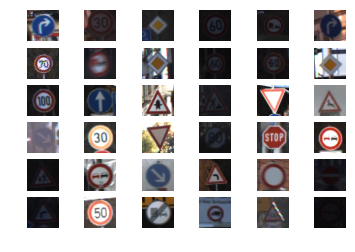

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

indices = np.random.randint(0, n_train, size=(6, 6))
f, axarr = plt.subplots(indices.shape[0], indices.shape[1])
for i, row in enumerate(indices):
    for j, index in enumerate(row):
        axarr[i, j].imshow(X_train[index])
        axarr[i, j].axis('off')

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [4]:
import cv2

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized.reshape(32, 32, 1)
    

def preprocess(X):
    return np.array([preprocess_image(image) for image in X])

In [5]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

### Model Architecture

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    layer1  = conv1
    
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    layer2  = conv2
    
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    fc0   = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, [layer1, layer2]

### Train, Validate and Test the Model

In [7]:
from sklearn.utils import shuffle

EPOCHS = 100
BATCH_SIZE = 128
rate = 0.0005

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

logits, layers = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

sess = tf.Session()

In [8]:
with sess.as_default():    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})
            
        print("EPOCH {} ...".format(i+1))
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.175
Validation Accuracy = 0.157

EPOCH 2 ...
Training Accuracy = 0.337
Validation Accuracy = 0.300

EPOCH 3 ...
Training Accuracy = 0.401
Validation Accuracy = 0.360

EPOCH 4 ...
Training Accuracy = 0.453
Validation Accuracy = 0.416

EPOCH 5 ...
Training Accuracy = 0.539
Validation Accuracy = 0.497

EPOCH 6 ...
Training Accuracy = 0.594
Validation Accuracy = 0.558

EPOCH 7 ...
Training Accuracy = 0.643
Validation Accuracy = 0.602

EPOCH 8 ...
Training Accuracy = 0.721
Validation Accuracy = 0.678

EPOCH 9 ...
Training Accuracy = 0.747
Validation Accuracy = 0.706

EPOCH 10 ...
Training Accuracy = 0.763
Validation Accuracy = 0.719

EPOCH 11 ...
Training Accuracy = 0.787
Validation Accuracy = 0.743

EPOCH 12 ...
Training Accuracy = 0.816
Validation Accuracy = 0.758

EPOCH 13 ...
Training Accuracy = 0.825
Validation Accuracy = 0.769

EPOCH 14 ...
Training Accuracy = 0.857
Validation Accuracy = 0.789

EPOCH 15 ...
Training Accuracy = 0.874
Valid

In [9]:
with sess.as_default():   
    saver.restore(sess, './lenet')
    train_accuracy = sess.run(accuracy_operation, feed_dict={x: X_train, y: y_train, keep_prob: 1.0})
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    valid_accuracy = sess.run(accuracy_operation, feed_dict={x: X_valid, y: y_valid, keep_prob: 1.0})
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob: 1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Train Accuracy = 0.997
Validation Accuracy = 0.961
Test Accuracy = 0.934


---

## Step 3: Test a Model on New Images

### Load and Output the Images

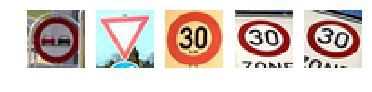

In [10]:
import cv2

images = [cv2.imread('internet-examples/{0}.png'.format(i)) for i in range(5)]
images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]
labels = [9, 13, 1, 1, 1]

f, axarr = plt.subplots(1, 5)
index = 0
for i in range(5):
    axarr[i].imshow(images[i])
    axarr[i].axis('off')

### Pre-process the Images

In [11]:
images = preprocess(images)

### Predict the Sign Type for Each Image

In [12]:
with sess.as_default():   
    saver.restore(sess, './lenet')
    signs = sess.run(tf.argmax(logits, 1), feed_dict={x: images, keep_prob: 1.0})

for sign in signs:
    print(sign_names[sign])

No passing
Yield
Speed limit (30km/h)
Speed limit (30km/h)
Turn right ahead


### Analyze Performance

In [13]:
with sess.as_default():   
    saver.restore(sess, './lenet')
    accuracy = sess.run(accuracy_operation, feed_dict={x: images, y: labels, keep_prob: 1.0})
    
print('Accuracy = {:2.0f}%'.format(100*accuracy))

Accuracy = 80%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [14]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
with sess.as_default():   
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: images, keep_prob: 1.0})
    for probabilities, classes in zip(top_k.values, top_k.indices):
        print(probabilities), print([sign_names[sign] for sign in classes])

[ 1.  0.  0.  0.  0.]
['No passing', 'End of no passing', 'Vehicles over 3.5 metric tons prohibited', 'Slippery road', 'Speed limit (60km/h)']
[ 1.  0.  0.  0.  0.]
['Yield', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)']
[ 0.78  0.22  0.    0.    0.  ]
['Speed limit (30km/h)', 'End of speed limit (80km/h)', 'End of no passing by vehicles over 3.5 metric tons', 'End of all speed and passing limits', 'Priority road']
[ 0.77  0.22  0.01  0.    0.  ]
['Speed limit (30km/h)', 'End of speed limit (80km/h)', 'Speed limit (80km/h)', 'End of all speed and passing limits', 'End of no passing by vehicles over 3.5 metric tons']
[ 0.98  0.02  0.    0.    0.  ]
['Turn right ahead', 'Stop', 'Keep left', 'Keep right', 'Go straight or left']


---

## Step 4: Visualize the Neural Network's State with Test Images


In [15]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

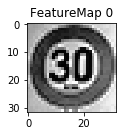

In [16]:
input_image = images[2].reshape(1, 32, 32, 1)
with sess.as_default():  
    outputFeatureMap(input_image, x)

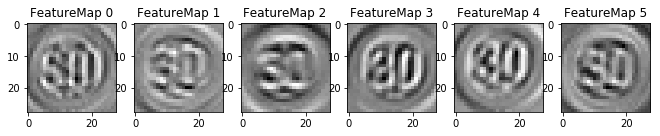

In [17]:
with sess.as_default():  
    outputFeatureMap(input_image, layers[0])

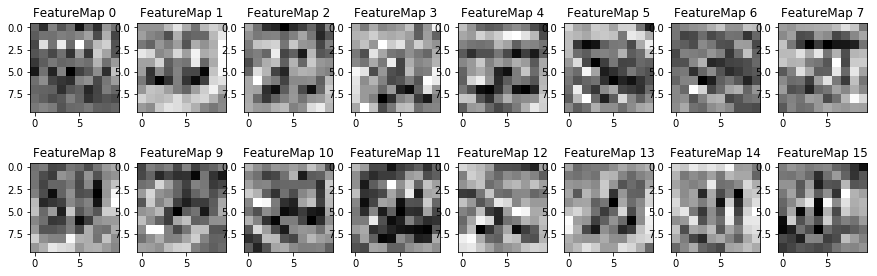

In [18]:
with sess.as_default():  
    outputFeatureMap(input_image, layers[1])